<a href="https://colab.research.google.com/github/singwang-cn/Neural-Network/blob/master/CNN_with_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch 
from torch.utils import data
from torch.autograd import Variable
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [ ]:
!pip install wandb
import wandb
wandb.login()

     |████████████████████████████████| 1.8 MB 5.3 MB/s 
     |████████████████████████████████| 144 kB 38.1 MB/s 
     |████████████████████████████████| 181 kB 44.3 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=4991cb6c2c53c155bd9363df1b406904b0c49c016c91ac2e383aceaa7e7462f8
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [1]:
!pip install cloud-tpu-client==0.10 torch==1.11.0 https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-1.11-cp37-cp37m-linux_x86_64.whl

  Using cached https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-1.11-cp37-cp37m-linux_x86_64.whl (152.9 MB)
  Using cached torch-1.11.0-cp37-cp37m-manylinux1_x86_64.whl (750.6 MB)
  Attempting uninstall: torch
    Found existing installation: torch 1.9.0
    Uninstalling torch-1.9.0:
      Successfully uninstalled torch-1.9.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.10.0 requires torch==1.9.0, but you have torch 1.11.0 which is incompatible.


In [4]:
!pip3 install torchvision==0.10.0

     |████████████████████████████████| 22.1 MB 1.6 MB/s 
     |████████████████████████████████| 831.4 MB 2.3 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0
    Uninstalling torch-1.11.0:
      Successfully uninstalled torch-1.11.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.12.0 requires torch==1.11.0, but you have torch 1.9.0 which is incompatible.
torchaudio 0.11.0+cu113 requires torch==1.11.0, but you have torch 1.9.0 which is incompatible.


In [2]:
import torch_xla
import torch_xla.core.xla_model as xm

In [1]:
import torch
import torch.nn as nn
from torch.nn import init
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset
import numpy as np
import matplotlib.pyplot as plt

In [3]:
mnist_tr = dset.MNIST("./dataset/mnist", train=True, download=True, transform=T.ToTensor())
mnist_te = dset.MNIST("./dataset/mnist", train=False, download=True, transform=T.ToTensor())

NUM_TRAIN = 60000
NUM_VALID = 60000
NUM_TEST = 10000

batch_size = 128

loader_tr = DataLoader(mnist_tr, batch_size=batch_size, shuffle=True)
loader_va = DataLoader(mnist_tr, batch_size=batch_size, shuffle=True)
loader_te = DataLoader(mnist_te, batch_size=batch_size, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./dataset/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./dataset/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./dataset/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./dataset/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/mnist/MNIST/raw



In [ ]:
def build_classifier():
  return nn.Sequential(
    nn.Conv2d(in_channels=1,
              out_channels=16,
              kernel_size=3,
              stride=2,
              padding=1,
              padding_mode='zeros',
              bias=True),
    nn.LeakyReLU(0.01),
    nn.MaxPool2d(kernel_size=2,
                 stride=1,
                 padding=1),
    nn.Conv2d(in_channels=16,
              out_channels=32,
              kernel_size=3,
              stride=2,
              padding=0,
              bias=True),
    nn.LeakyReLU(0.01),
    nn.MaxPool2d(kernel_size=2,
                 stride=1,
                 padding=0),
    nn.Conv2d(in_channels=32,
              out_channels=64,
              kernel_size=3,
              stride=2,
              padding=0,
              bias=True),
    nn.Flatten(start_dim=1, end_dim=-1),
    nn.Linear(64*2*2, 100),
    nn.LeakyReLU(0.01),
    nn.Linear(100, 10),
    nn.Softmax(dim=1)
)

In [ ]:
dtype = torch.cuda.FloatTensor
model = build_classifier().cuda(0)
cost_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)
cost_list = []
for epoch in range(5):
  for x, y in loader_tr:
    #if len(x) != batch_size:
      #continue
    y_hat = model(x.type(dtype)).cpu()
    cost = cost_func(y_hat, y)
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    cost_list.append(cost.detach().numpy())

  incorrect = 0
  for x, y in loader_va:
    y_hat = model(x.type(dtype)).cpu().detach().numpy().argmax(axis=1)
    for i in range(len(y)):
      if y[i] != y_hat[i]:
        incorrect += 1
  print('epoch:{}, acurracy:{:.3f}, error rate:{:.3f}'.format(epoch+1, 1-incorrect/60000, incorrect/60000))

epoch:1, acurracy:0.951, error rate:0.049
epoch:2, acurracy:0.966, error rate:0.034
epoch:3, acurracy:0.971, error rate:0.029
epoch:4, acurracy:0.978, error rate:0.022
epoch:5, acurracy:0.977, error rate:0.023


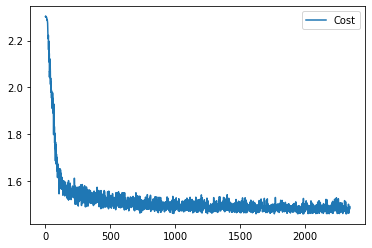

In [ ]:
plt.figure('PyTorch_CNN_Cost')
plt.plot(cost_list,label='Cost')
plt.legend()

In [ ]:
incorrect = 0
for x, y in loader_te:
  y_hat = model(x.type(dtype)).cpu().detach().numpy().argmax(axis=1)
  for i in range(len(y)):
    if y[i] != y_hat[i]:
      incorrect += 1
print('Test: acurracy:{:.3f}, error rate:{:.3f}'.format(1-incorrect/10000, incorrect/10000))

Test: acurracy:0.979, error rate:0.021


In [2]:
cifar10_tr = dset.CIFAR10("./dataset/cifar10", train=True, download=True, transform=T.ToTensor())
cifar10_te = dset.CIFAR10("./dataset/cifar10", train=False, download=True, transform=T.ToTensor())

NUM_TRAIN = 50000
#NUM_VALID = 50000
NUM_TEST = 10000

batch_size = 128

loader_tr = DataLoader(cifar10_tr, batch_size=batch_size, shuffle=True)
#loader_va = DataLoader(cifar10_tr, batch_size=batch_size, shuffle=True)
loader_te = DataLoader(cifar10_te, batch_size=batch_size, shuffle=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./dataset/cifar10/cifar-10-python.tar.gz to ./dataset/cifar10
Files already downloaded and verified


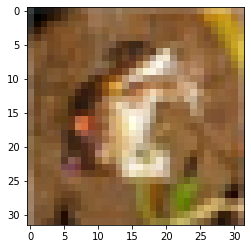

In [ ]:
plt.imshow(cifar10_tr[0][0].numpy().T)

In [ ]:
cifar10_te.data.shape

(10000, 32, 32, 3)

In [3]:
def build_classifier():
  return nn.Sequential(
    nn.Conv2d(in_channels=3,
              out_channels=64,
              kernel_size=3,
              stride=2,
              padding=2,
              padding_mode='zeros',
              bias=True),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2,
                 stride=1,),
    nn.Conv2d(in_channels=64,
              out_channels=128,
              kernel_size=3,
              stride=2,
              padding=1,
              bias=True),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2,
                 stride=1,
                 padding=0),
    nn.Conv2d(in_channels=128,
              out_channels=256,
              kernel_size=3,
              stride=2,
              padding=1,
              bias=True),
    nn.MaxPool2d(kernel_size=2,
                 stride=1,
                 padding=0),
    nn.Flatten(start_dim=1, end_dim=-1),
    nn.Linear(256*3*3, 256*3*3),
    nn.ReLU(),
    nn.Linear(256*3*3, 10),
    nn.Softmax(dim=1)
)

In [5]:
dev = xm.xla_device(n=8, devkind='TPU')

In [5]:
dtype = torch.cuda.FloatTensor
model = build_classifier().cuda(0)
#model = build_classifier().to(dev)
cost_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.0001)
cost_list = []
for epoch in range(200):
  for x, y in loader_tr:
    #if len(x) != batch_size:
      #continue
    y_hat = model(x.type(dtype)).cpu()
    #y_hat = model(x.to(dev))
    cost = cost_func(y_hat, y)
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    #cost_list.append(cost.detach().numpy())

  if (epoch+1)%5 == 0:
    cost_list.append(cost.detach().numpy())
    incorrect = 0
    for x, y in loader_te:
      y_hat = model(x.type(dtype)).cpu().detach().numpy().argmax(axis=1)
      #y_hat = model(x).detach().numpy().argmax(axis=1)
      for i in range(len(y)):
        if y[i] != y_hat[i]:
          incorrect += 1
    print('epoch:{}, acurracy:{:.3f}, error rate:{:.3f}'.format(epoch+1, 1-incorrect/10000, incorrect/10000))

epoch:5, acurracy:0.531, error rate:0.469
epoch:10, acurracy:0.588, error rate:0.412
epoch:15, acurracy:0.619, error rate:0.381
epoch:20, acurracy:0.655, error rate:0.345
epoch:25, acurracy:0.668, error rate:0.332
epoch:30, acurracy:0.683, error rate:0.317
epoch:35, acurracy:0.692, error rate:0.308
epoch:40, acurracy:0.698, error rate:0.302
epoch:45, acurracy:0.700, error rate:0.300
epoch:50, acurracy:0.712, error rate:0.288
epoch:55, acurracy:0.709, error rate:0.291
epoch:60, acurracy:0.711, error rate:0.289
epoch:65, acurracy:0.709, error rate:0.291
epoch:70, acurracy:0.711, error rate:0.289
epoch:75, acurracy:0.713, error rate:0.287
epoch:80, acurracy:0.721, error rate:0.279
epoch:85, acurracy:0.725, error rate:0.275
epoch:90, acurracy:0.720, error rate:0.280
epoch:95, acurracy:0.721, error rate:0.279
epoch:100, acurracy:0.721, error rate:0.279
epoch:105, acurracy:0.721, error rate:0.279
epoch:110, acurracy:0.719, error rate:0.281
epoch:115, acurracy:0.728, error rate:0.272
epoch:12

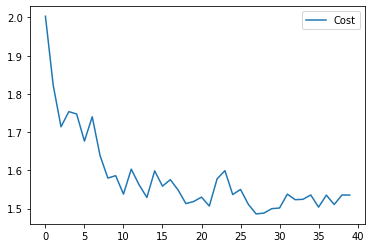

In [6]:
plt.figure('PyTorch_CNN_Cost')
plt.plot(cost_list,label='Cost')
plt.legend()